# Stroke type proportions with onset-to-arrival time

Find how the proportions of stroke types vary in subgroups of patients with different onset-to-arrival times.

## Plain English summary

It's useful in our modelling to know about the breakdown of stroke types in a group of patients. We would like to know what fraction of patients have a haemorrhagic stroke, what fraction have a LVO, and what fraction have an nLVO.

However, these fractions change when we look at different subgroups of patients. If you look at a group of patients who all arrived at hospital within an hour of their stroke beginning, then you would expect to see mostly very severe strokes. The patients who arrive at hospital soonest usually have obvious and recognisable symptoms and people will have called for help very quickly, but patients having a mild stroke will take longer on average to call for help and arrive at hospital.

In this notebook, we use the SSNAP data to see which patients arrive at hospital before various cutoff times. We use a cutoff time of each hour in turn - first all the patients who arrived at hospital within one hour, then within two hours, all the way up to arrivals within 24 hours. For the patients who arrived before the cutoff time, we record how many have each stroke type and save a copy of the results.

## Aims

Find the proportions of patients with each stroke type in each subgroup of patients who arrive at hospital before the cutoff time for cutoff times of one to 24 hours.

Save a copy of a file containing:
+ one row for each cutoff time from one hour to 24 hours
+ one column for each proportion measured. These are:  
  ... within the expected time:
  + (1): proportion overall who arrive within the expected time
  + proportion of (1) with haemorrhagic stroke
  + proportion of (1) with nLVO
  + proportion of (1) with LVO
  + proportion of all patients with haemorrhagic stroke and who arrive within the expected time
  + proportion of all patients with nLVO and who arrive within the expected time
  + proportion of all patients with LVO and who arrive within the expected time

  ... and after the expected time:
  + proportion of "patients who arrive after the expected time" with haemorrhagic stroke
  + proportion of "patients who arrive after the expected time" with nLVO
  + proportion of "patients who arrive after the expected time" with LVO
  + proportion of all patients with haemorrhagic stroke and who arrive after the expected time
  + proportion of all patients with nLVO and who arrive after the expected time
  + proportion of all patients with LVO and who arrive after the expected time

## Method

We use the cleaned SSNAP data and limit it to only patients who arrived by ambulance.

Then for each expected onset-to-arrival time in turn, split the data into patients who arrive within and who arrive after the expected time. For each group, find the proportion of patients with haemorrhagic stroke (their 'infarction' data is zero), the proportion of patients with nLVO (their 'stroke severity' is 10 or less) and the proportion of patients with LVO (their 'stroke severity' is 11 or more). Store a copy of the results.

Note: About 30% of patients who arrive by ambulance have missing onset-to-arrival time data. This means that any check of whether a missing time is less than the expected time will return False, and the patients with missing data will count as arriving after the expected time.

## Code setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load data

Load the cleaned SSNAP extract data:

In [2]:
path_to_ssnap = '~/ssnap_data/clean_samuel_ssnap_extract_v2.csv'
df_ssnap = pd.read_csv(path_to_ssnap)

Check the available data in the file:

In [3]:
df_ssnap.columns

Index(['id', 'stroke_team', 'age', 'male', 'infarction',
       'onset_to_arrival_time', 'onset_known', 'precise_onset_known',
       'onset_during_sleep', 'arrive_by_ambulance',
       'call_to_ambulance_arrival_time', 'ambulance_on_scene_time',
       'ambulance_travel_to_hospital_time', 'ambulance_wait_time_at_hospital',
       'month', 'year', 'weekday', 'arrival_time_3_hour_period',
       'arrival_to_scan_time', 'thrombolysis', 'scan_to_thrombolysis_time',
       'thrombectomy', 'arrival_to_thrombectomy_time',
       'congestive_heart_failure', 'hypertension', 'atrial_fibrillation',
       'diabetes', 'prior_stroke_tia', 'afib_antiplatelet',
       'afib_anticoagulant', 'afib_vit_k_anticoagulant',
       'afib_doac_anticoagulant', 'afib_heparin_anticoagulant',
       'new_afib_diagnosis', 'prior_disability', 'stroke_severity',
       'nihss_complete', 'nihss_arrival_loc', 'nihss_arrival_loc_questions',
       'nihss_arrival_loc_commands', 'nihss_arrival_best_gaze',
       'nihss_

Limit this to patients who arrived by ambulance:

In [4]:
df_ssnap = df_ssnap[df_ssnap['arrive_by_ambulance'] == 1].copy()

## Data ranges

Quickly check the contents of the onset-to-arrival times, infarction, and stroke severity columns.

### Onset to arrival times

Quick plot of arrival times up to 24 hours:

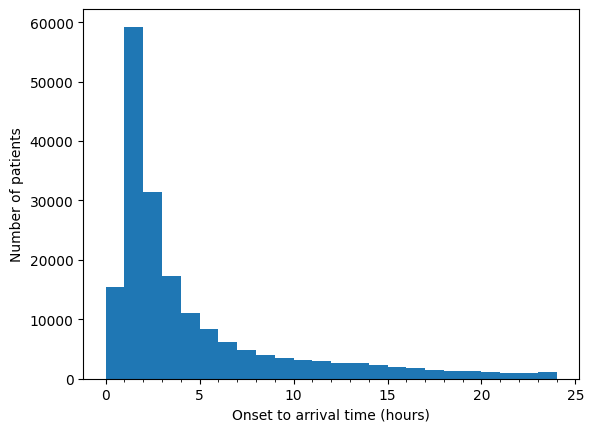

In [5]:
plt.hist(df_ssnap['onset_to_arrival_time'] / 60.0, bins=np.arange(0, 25, 1))
plt.xticks(np.arange(0, 25, 1), minor=True)
plt.xlabel('Onset to arrival time (hours)')
plt.ylabel('Number of patients')
plt.show()

Are any patients missing an onset to arrival time?

In [6]:
df_ssnap['onset_to_arrival_time'].isna().any()

True

What proportion of patients are missing this data?

In [7]:
df_ssnap['onset_to_arrival_time'].isna().sum() / len(df_ssnap)

0.2946326137988245

### Infarction

How many patients have an infarction? Assume the rest are haemorrhage.

In [8]:
df_ssnap['infarction'].value_counts()

1.0    245706
0.0     37579
Name: infarction, dtype: int64

What proportion is this?

In [9]:
df_ssnap['infarction'].mean()

0.8673456060151438

Check whether this value is missing for any patients:

In [10]:
df_ssnap['infarction'].isna().any()

False

### Stroke severity

Quick plot of stroke severity scores:

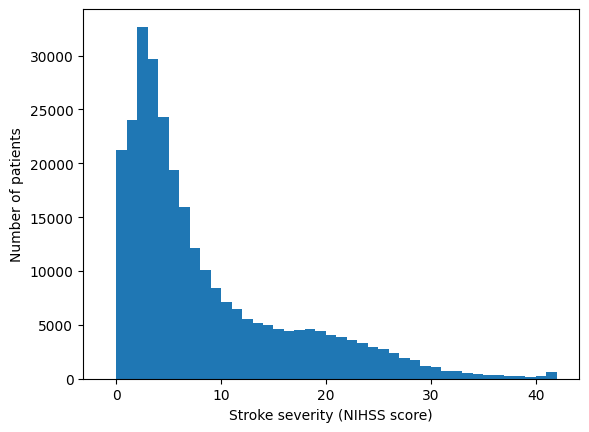

In [11]:
plt.hist(df_ssnap['stroke_severity'], bins=np.arange(-1, 43, 1))
plt.xlabel('Stroke severity (NIHSS score)')
plt.ylabel('Number of patients')
plt.show()

Are any patients missing this data?

In [12]:
df_ssnap['stroke_severity'].isna().any()

False

## Find proportions of patient subgroups for various time cutoffs

The following function calculates all of the proportions that we need for a given expected onset-to-arrival time.
+ It first finds which patients arrive on time and splits the patients into two dataframes using a mask.
  + One dataframe contains all patients who arrive within the time, the other dataframe contains everyone else.
+ Then for each dataframe it finds:
  + how many patients have haemorrhage ('infarction' is 1),
  + how many have nLVO and
  + how many have LVO (from stroke severity).
+ Then it converts the numbers of patients into proportions of patients. The proportions are found both out of the whole dataset and for just the arrived within/after the time subgroups.

In [13]:
def make_props_dict_for_arrival_time(
        df_ssnap: pd.DataFrame, expected_time: float
    ):
    """
    Find proportions of stroke types arriving within/after the expected time.

    Inputs
    ------
    df_ssnap    - pd.DataFrame. Cleaned SSNAP data limited to arrivals
                  by ambulance only. Has columns for onset to arrival
                  time, infarction, and stroke severity.
    expected_time - float. Cutoff onset-to-arrival time in minutes.

    Returns
    -------
    dict_here - dict. Dictionary of stroke type proportions.
    """
    # Store results in here:
    dict_here = {}
    # Make a copy of the input dataframe to save pandas shenanigans:
    df_here = df_ssnap.copy()

    # Find which patients arrive on time.
    mask = df_here['onset_to_arrival_time'] <= expected_time
    # Store the proportion of patients who arrive on time:
    prop_on_time = mask.mean()
    dict_here[f'prop_arriving_within_expected_time'] = prop_on_time
    # Keep separate dataframes of patients who arrive within and
    # who arrive after the time:
    dict_on_time = {
        'within': df_here[mask].copy(),
        'after': df_here[~mask].copy()
    }

    # For each of these subgroups...
    for label, df in dict_on_time.items():
        # Find the number of patients with a haemorrhage.
        mask_haemo = df['infarction'] != 1
        n_haemo = len(df[mask_haemo])

        # Separate just the patients with ischaemic stroke
        # (i.e. not a haemorrhage, assume cleaned data has already removed
        # any other patient stroke types).
        df_here_ischaemic = df[~mask_haemo]
        # Find which of these ischaemic patients have LVO:
        mask_lvo = df_here_ischaemic['stroke_severity'] > 10
        # Find how many patients have LVO and nLVO:
        n_lvo = len(df_here_ischaemic[mask_lvo])
        n_nlvo = len(df_here_ischaemic[~mask_lvo])

        # Convert the numbers of patients into proportions of patients.
        # This label is "within" for the masked data with only patients
        # arriving on time, and "after" for the other masked data
        s = f'arriving_{label}_expected_time'
        # Proportion of each subgroup out of arrival within/after time
        # subgroup:
        dict_here[f'prop_haemo_of_prop_{s}'] = n_haemo / len(df)
        dict_here[f'prop_nlvo_of_prop_{s}'] = n_nlvo / len(df)
        dict_here[f'prop_lvo_of_prop_{s}'] = n_lvo / len(df)

        # Proportion of each subgroup out of all patients:
        dict_here[f'prop_haemo_{s}'] = n_haemo / len(df_ssnap)
        dict_here[f'prop_nlvo_{s}'] = n_nlvo / len(df_ssnap)
        dict_here[f'prop_lvo_{s}'] = n_lvo / len(df_ssnap)

    return dict_here

Run this function for all of the expected onset-to-arrival times from one to 24 hours and store the results:

In [14]:
# Store the results in here:
dict_of_dicts = {}

for expected_time in np.arange(1.0, 25.0, 1.0):
    dict_of_dicts[str(expected_time)] = make_props_dict_for_arrival_time(df_ssnap, expected_time * 60.0)

Convert the results into a DataFrame and view them:

In [15]:
df = pd.DataFrame(dict_of_dicts).T
df.index.name = 'expected_time'

# Round the results to 5 decimal places (which should be plenty):
df = np.round(df, 5)

df

,prop_arriving_within_expected_time,prop_haemo_of_prop_arriving_within_expected_time,prop_nlvo_of_prop_arriving_within_expected_time,prop_lvo_of_prop_arriving_within_expected_time,prop_haemo_arriving_within_expected_time,prop_nlvo_arriving_within_expected_time,prop_lvo_arriving_within_expected_time,prop_haemo_of_prop_arriving_after_expected_time,prop_nlvo_of_prop_arriving_after_expected_time,prop_lvo_of_prop_arriving_after_expected_time,prop_haemo_arriving_after_expected_time,prop_nlvo_arriving_after_expected_time,prop_lvo_arriving_after_expected_time
expected_time,,,,,,,,,,,,,
1.0,0.05991,0.15957,0.49172,0.34871,0.00956,0.02946,0.02089,0.13094,0.66410,0.20496,0.12310,0.62431,0.19269
2.0,0.26796,0.15649,0.54775,0.29576,0.04193,0.14678,0.07925,0.12393,0.69258,0.18349,0.09072,0.50699,0.13432
3.0,0.37680,0.15302,0.57470,0.27227,0.05766,0.21655,0.10259,0.12034,0.70157,0.17809,0.07500,0.43722,0.11098
4.0,0.43734,0.15031,0.58849,0.26120,0.06574,0.25737,0.11423,0.11893,0.70451,0.17656,0.06692,0.39640,0.09935
5.0,0.47625,0.14795,0.59724,0.25481,0.07046,0.28443,0.12135,0.11875,0.70517,0.17608,0.06220,0.36933,0.09222
6.0,0.50532,0.14613,0.60356,0.25031,0.07384,0.30499,0.12649,0.11889,0.70506,0.17605,0.05881,0.34878,0.08709
7.0,0.52709,0.14467,0.60875,0.24658,0.07625,0.32087,0.12997,0.11927,0.70394,0.17679,0.05640,0.33290,0.08360
8.0,0.54381,0.14351,0.61259,0.24390,0.07804,0.33313,0.13263,0.11971,0.70285,0.17743,0.05461,0.32064,0.08094
9.0,0.55778,0.14252,0.61602,0.24145,0.07950,0.34360,0.13468,0.12021,0.70138,0.17842,0.05316,0.31016,0.07890


## Save results to file

In [19]:
df.to_csv('stroke_type_proportions_with_arrival_time.csv')

## Plot proportions over time

We can make a stacked bar chart to see how the stroke type proportions vary with the expected onest-to-arrival time.

Setup for the plot is in the following cell. It gives which proportions should be plotted and in which order, how they should be labelled on the legend, and what colour each should be.

In [20]:
layers_to_stack = [
    'prop_nlvo_arriving_within_expected_time',
    'prop_lvo_arriving_within_expected_time',
    'prop_haemo_arriving_within_expected_time',
    'prop_nlvo_arriving_after_expected_time',
    'prop_lvo_arriving_after_expected_time',
    'prop_haemo_arriving_after_expected_time',
]

stack_labels = {
    'prop_nlvo_arriving_within_expected_time': 'Arriving within expected time: nLVO',
    'prop_lvo_arriving_within_expected_time': 'Arriving within expected time: LVO',
    'prop_haemo_arriving_within_expected_time': 'Arriving within expected time: Haemorrhagic',
    'prop_nlvo_arriving_after_expected_time': 'Arriving after expected time: nLVO',
    'prop_lvo_arriving_after_expected_time': 'Arriving after expected time: LVO',
    'prop_haemo_arriving_after_expected_time': 'Arriving after expected time: Haemorrhagic',
}

stack_colours = {
    'prop_nlvo_arriving_within_expected_time': '#d55e00',
    'prop_lvo_arriving_within_expected_time': '#0072b2',
    'prop_haemo_arriving_within_expected_time': 'grey',
    'prop_nlvo_arriving_after_expected_time': '#d59a6b',
    'prop_lvo_arriving_after_expected_time': '#7aafcc',
    'prop_haemo_arriving_after_expected_time': 'silver',
}

The actual plotting:

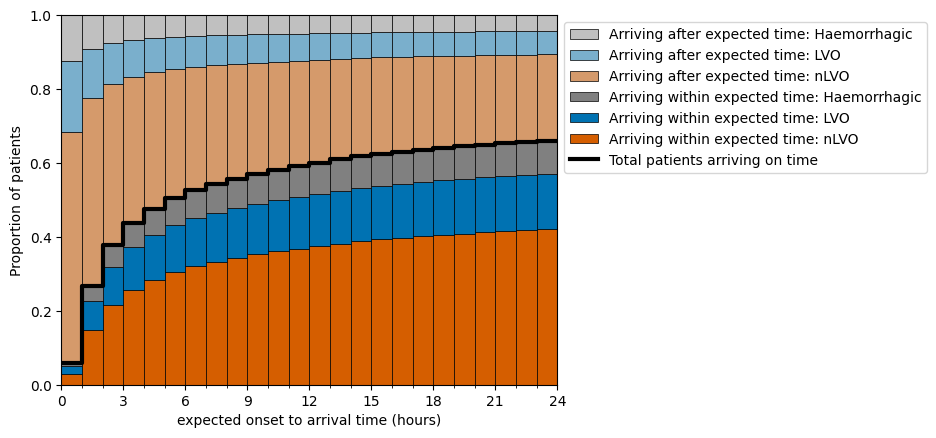

In [22]:
# One value for each expected time, where the bottom of the next
# bar up should be drawn. Starts at zero for the first set of bars
# and then the bar heights are added on each time they're drawn.
bottoms = np.full(len(df.index), 0.0)

fig, ax = plt.subplots()

# Draw the bars for each layer in turn:
for i, layer in enumerate(layers_to_stack):
    vals = df[layer]
    ax.bar(
        x=df.index.values.astype(float) - 0.5,
        height=vals,
        label=stack_labels[layer],
        bottom=bottoms,
        facecolor=stack_colours[layer],
        edgecolor='k',
        linewidth=0.5,
        width=1.0
    )
    bottoms += vals

# Draw a line separating the patients arriving on time from those who don't:
y_line = np.stack([
    df['prop_arriving_within_expected_time'],
    df['prop_arriving_within_expected_time']
]).transpose().flatten()
x_line = np.stack([
    df.index.values.astype(float),
    df.index.values.astype(float)
]).transpose().flatten()[1:]
x_line = np.append(x_line, x_line[-1] + 1.0)
x_line -= 1.0

ax.plot(x_line, y_line, color='k', linewidth=3.0, label='Total patients arriving on time')

# Other plot setup:
ax.legend(bbox_to_anchor=[1.0, 1.0], reverse=True)

ax.set_ylim(0.0, 1.0)
ax.set_xlim(0, 24)
ax.set_xticks(np.arange(0, 25, 3))
ax.set_xticks(np.arange(0, 25, 1), minor=True)

ax.set_xlabel('expected onset to arrival time (hours)')
ax.set_ylabel('Proportion of patients')

plt.savefig('stroke_type_proportions_expected_arrival_time.png', bbox_inches='tight')
plt.show()